In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rotation_tools import RotationSimulation, RotationalState
from scipy.spatial.transform import Rotation as R
plt.rcParams.update({'font.family': 'serif', 'font.size': 12, 'mathtext.fontset': 'cm'})

In [2]:
true_P = 21.28
e_period = 2022.5 # secular oscillation period in units where hyperion's orbital period is 2pi

N = 100
P = 2*np.pi
ts = np.arange(0, N*P, P/100)
t_offset = {'cas1':0,'cas2':67,'cas3':107, 'cascorr1':0,'cascorr2':67,'cascorr3':107}

all_obs = {}
fid_sim = {}
M = {}
harb_rot = R.from_euler('ZXZ', [40, 20, 10], degrees=True)
id_rot = R.from_euler('ZXZ', [0, 0, 0], degrees=True)

black_theta0 = 0.5776584
black_phi0 = 2.3123878
black_psi0 = 2.2597257
black_thetadot0 = 3.5542896
black_phidot0 = -3.3128323
black_psidot0 = 2.3196794
black_omegaa0 = black_thetadot0*np.sin(black_phi0)*np.sin(black_psi0) + black_phidot0*np.cos(black_psi0)
black_omegab0 = black_thetadot0*np.sin(black_phi0)*np.cos(black_psi0) - black_phidot0*np.sin(black_psi0)
black_omegac0 = black_thetadot0*np.cos(black_phi0) + black_psidot0

all_inits = {'black':{'e':0.1236, 'M0':np.radians(20.0065), 'theta0':0.5776584, 'phi0':2.3123878, 'psi0':2.2597257, 'omega0':3.5542896, 'omegaa0':black_omegaa0, 'omegab0':black_omegab0, 'omegac0':black_omegac0, 'A':0.3234, 'B':0.4597, 'C':0.5192, 'princip_ax_rot':id_rot},
 'cas1':{'e':0.115, 'M0':np.radians(295), 'theta0':0.004, 'phi0':1.441, 'psi0':0.427, 'omega0':4.433, 'omegaa0':4.433*0.890, 'omegab0':4.433*0.067, 'omegac0':4.433*0.451, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':id_rot},
 'cas2':{'e':0.115, 'M0':np.radians(342), 'theta0':1.885, 'phi0':2.118, 'psi0':1.180, 'omega0':4.255, 'omegaa0':4.255*0.907, 'omegab0':4.255*0.162, 'omegac0':4.255*0.389, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':id_rot},
 'cas3':{'e':0.113, 'M0':np.radians(303), 'theta0':2.989, 'phi0':1.685, 'psi0':1.641, 'omega0':4.255, 'omegaa0':4.255*0.902, 'omegab0':4.255*0.133, 'omegac0':4.255*0.411, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':id_rot},
 'cascorr1':{'e':0.115, 'M0':np.radians(295), 'theta0':0.004, 'phi0':1.441, 'psi0':0.427, 'omega0':4.433, 'omegaa0':4.433*0.890, 'omegab0':4.433*0.067, 'omegac0':4.433*0.451, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':harb_rot},
 'cascorr2':{'e':0.115, 'M0':np.radians(342), 'theta0':1.885, 'phi0':2.118, 'psi0':1.180, 'omega0':4.255, 'omegaa0':4.255*0.907, 'omegab0':4.255*0.162, 'omegac0':4.255*0.389, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':harb_rot},
 'cascorr3':{'e':0.113, 'M0':np.radians(303), 'theta0':2.989, 'phi0':1.685, 'psi0':1.641, 'omega0':4.255, 'omegaa0':4.255*0.902, 'omegab0':4.255*0.133, 'omegac0':4.255*0.411, 'A':0.314, 'B':0.474, 'C':0.542, 'princip_ax_rot':harb_rot}}

for name, inits in all_inits.items():
    body_rot = R.from_euler('ZXZ', [inits['theta0'], inits['phi0'], inits['psi0']], degrees=False)
    omegaa0, omegab0, omegac0 = (body_rot.inv() * inits['princip_ax_rot'].inv() * body_rot).inv().apply([inits['omegaa0'], inits['omegab0'], inits['omegac0']])
    theta0, phi0, psi0 = (inits['princip_ax_rot'].inv() * body_rot).as_euler('ZXZ')
    all_obs[name] = RotationalState([theta0, phi0, psi0, omegaa0, omegab0, omegac0], A=inits['A'], B=inits['B'], C=inits['C'])
    fid_sim[name] = RotationSimulation(A=inits['A'], B=inits['B'], C=inits['C'], e_forced=inits['e'], e_free=0.0, e_period=e_period, n=1.0, M0=inits['M0'])
    fid_sim[name].integrate(ts, all_obs[name])
    M[name] = fid_sim[name].sol.t + inits['M0']

In [3]:
# permute_axes = [[0, 0, 1], [0, -1, 0], [1, 0, 0]]
permute_axes= [[0, 1, 0], [0, 0, 1], [1, 0, 0]]
for name, obs in all_obs.items():
    print(name)
    print('Andoyer:', obs.andoyer(permute_axes))
    print('Scaled actions:', obs.andoyer(permute_axes)[:3]/((obs.B+obs.C)/2))
    print("Lambda' =",obs.andoyer(permute_axes)[1] - 2*obs.andoyer(permute_axes)[0])
    print('rho:', 3*((obs.C+obs.B)/2-obs.A)/((obs.C+obs.B)/2))
    print('')

black
Andoyer: [ 1.39742541  0.59652648  1.33536984  2.22088523 -0.59553722  1.67323668]
Scaled actions: [2.8550933  1.21876898 2.72830696]
Lambda' = -2.1983243508148216
rho: 1.0177750536316272

cas1
Andoyer: [1.65189994 0.77606147 1.23884618 1.67085457 0.82713448 0.12919672]
Scaled actions: [3.25177153 1.52768006 2.43867358]
Lambda' = -2.5277384073105287
rho: 1.1456692913385829

cas2
Andoyer: [1.54274682 0.5963635  1.21181549 2.58947925 1.99734544 0.34927208]
Scaled actions: [3.03690319 1.1739439  2.38546356]
Lambda' = -2.489130143886741
rho: 1.1456692913385829

cas3
Andoyer: [1.55651193 1.06762875 1.20513514 3.19111869 2.67288137 0.2757899 ]
Scaled actions: [3.06399987 2.1016314  2.37231327]
Lambda' = -2.045395113519546
rho: 1.1456692913385829

cascorr1
Andoyer: [1.43683534 0.59855614 1.36869538 4.03154952 1.22362339 3.19187154]
Scaled actions: [2.82841603 1.17826012 2.69428224]
Lambda' = -2.275114544591468
rho: 1.1456692913385829

cascorr2
Andoyer: [1.35955128 0.68298847 1.31770704 

In [4]:
R.from_matrix(permute_axes).as_euler('ZXZ')

array([3.14159265, 1.57079633, 1.57079633])

In [5]:
for name, sim in fid_sim.items():
    print(name, f'{sim.M0:.3f}')

black 0.349
cas1 5.149
cas2 5.969
cas3 5.288
cascorr1 5.149
cascorr2 5.969
cascorr3 5.288


In [6]:
for name, obs in all_obs.items():
    print(name, np.array([np.remainder(obs.euler[:3], 2*np.pi), obs.euler[3:]/obs.omega]), obs.omega, '\n')

black [[ 0.5776584   2.3123878   2.2597257 ]
 [ 0.97731561  0.21091622 -0.01919746]] 4.224999989526444 

cas1 [[0.004      1.441      0.427     ]
 [0.89000445 0.06700034 0.45100226]] 4.432977834944587 

cas2 [[1.885      2.118      1.18      ]
 [0.90690297 0.16198267 0.38895838]] 4.255455260644858 

cas3 [[2.989      1.685      1.641     ]
 [0.9019035  0.13298577 0.41095603]] 4.255455260644858 

cascorr1 [[ 5.35201232  1.17851752  0.6660528 ]
 [ 0.98328993 -0.01045772 -0.18174583]] 4.432977834944587 

cascorr2 [[ 0.85264881  1.96007422  0.83014049]
 [ 0.98615047 -0.16558558  0.0094158 ]] 4.255455260644859 

cascorr3 [[ 2.05376458  1.90832408  1.36501846]
 [ 0.98303411 -0.0950449   0.15687707]] 4.255455260644858 



In [7]:
with np.printoptions(precision=3, suppress=True):
    for name, obs in all_obs.items():
        corr_euler = RotationalState.from_andoyer(*obs.andoyer(permute_axes), A=obs.B, B=obs.C, C=obs.A).euler
        print(name, np.remainder(corr_euler[:3], 2*np.pi), corr_euler[3:]/obs.omega)

black [5.676 0.965 3.448] [ 0.211 -0.019  0.977]
cas1 [1.713 1.148 1.508] [0.067 0.451 0.89 ]
cas2 [0.559 0.661 0.587] [0.162 0.389 0.907]
cas3 [5.734 0.134 0.705] [0.133 0.411 0.902]
cascorr1 [2.055 0.963 2.21 ] [-0.01  -0.182  0.983]
cascorr2 [1.025 0.819 1.112] [-0.166  0.009  0.986]
cascorr3 [0.527 0.393 0.525] [-0.095  0.157  0.983]


In [8]:
# permute_axes = [[0, 0, 1], [0, -1, 0], [1, 0, 0]]
# permute_axes= [[0, 1, 0], [0, 0, 1], [1, 0, 0]]
andoyer = {name: sim.sol.andoyer(permute_axes=permute_axes) for name, sim in fid_sim.items()}
G = {name: a[0] for name, a in andoyer.items()}
Lambda = {name: a[1] for name, a in andoyer.items()}
L = {name: a[2] for name, a in andoyer.items()}
g = {name: a[3] for name, a in andoyer.items()}
lambda_node = {name: a[4] for name, a in andoyer.items()}
l = {name: a[5] for name, a in andoyer.items()}

In [9]:
i_obs = 'cascorr1'

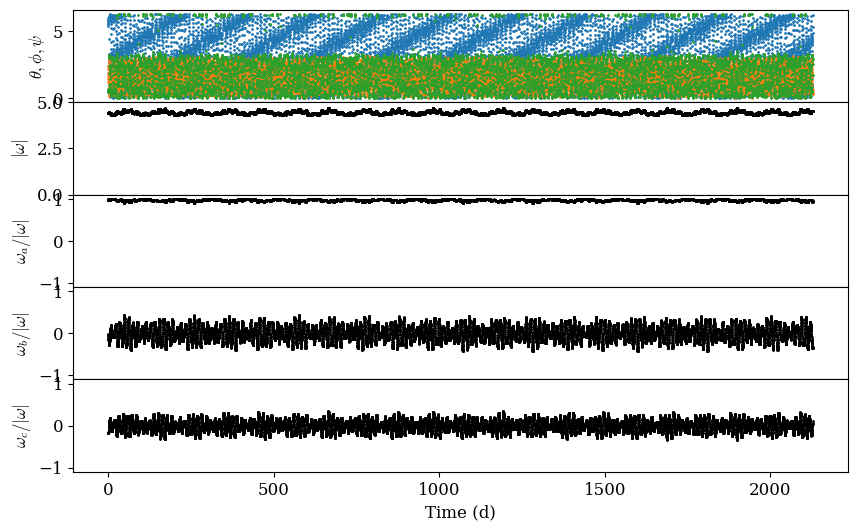

In [10]:
fig, axs = plt.subplots(5, 1, figsize=(10, 6), sharex=True, gridspec_kw={'hspace': 0})
for i in range(3):
    axs[0].scatter(fid_sim[i_obs].sol.t/(2*np.pi)*true_P, np.remainder(fid_sim[i_obs].sol.euler[:,i], 2*np.pi), s=1, alpha=1, linestyle='None')
axs[1].scatter(fid_sim[i_obs].sol.t/(2*np.pi)*true_P, fid_sim[i_obs].sol.omega, s=1, alpha=1, color='k')
axs[2].scatter(fid_sim[i_obs].sol.t/(2*np.pi)*true_P, fid_sim[i_obs].sol.omegaa/fid_sim[i_obs].sol.omega, s=1, alpha=1, color='k')
axs[3].scatter(fid_sim[i_obs].sol.t/(2*np.pi)*true_P, fid_sim[i_obs].sol.omegab/fid_sim[i_obs].sol.omega, s=1, alpha=1, color='k')
axs[4].scatter(fid_sim[i_obs].sol.t/(2*np.pi)*true_P, fid_sim[i_obs].sol.omegac/fid_sim[i_obs].sol.omega, s=1, alpha=1, color='k')
axs[0].set_ylabel(r'$\theta, \phi, \psi$')
axs[1].set_ylabel('$|\omega|$')
axs[2].set_ylabel('$\omega_a/|\omega|$')
axs[3].set_ylabel('$\omega_b/|\omega|$')
axs[4].set_ylabel('$\omega_c/|\omega|$')
axs[4].set_xlabel('Time (d)')
axs[1].set_ylim(0, 5)
for ax in axs[2:]:
    ax.set_ylim(-1.1, 1.1)
# axs[0].set_xlim(0, 100)

(0.0, 20.0)

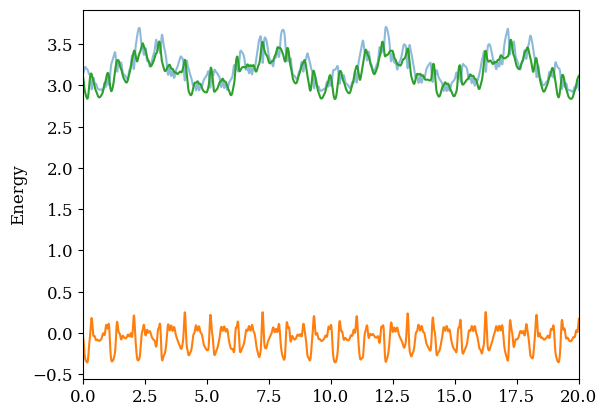

In [11]:
T = 0.5*(fid_sim[i_obs].A*fid_sim[i_obs].sol.omegaa**2 + fid_sim[i_obs].B*fid_sim[i_obs].sol.omegab**2 + fid_sim[i_obs].C*fid_sim[i_obs].sol.omegac**2)
fs = np.array([fid_sim[i_obs].get_rf(t)[1] for t in fid_sim[i_obs].sol.t])
rs = np.array([fid_sim[i_obs].get_rf(t)[0] for t in fid_sim[i_obs].sol.t])
alpha, beta, gamma = fid_sim[i_obs].sol.cosines(fs)
maccullagh_f = (fid_sim[i_obs].B + fid_sim[i_obs].C - 2*fid_sim[i_obs].A)*alpha**2 + \
                (fid_sim[i_obs].C + fid_sim[i_obs].A - 2*fid_sim[i_obs].B)*beta**2 + \
                (fid_sim[i_obs].A + fid_sim[i_obs].B - 2*fid_sim[i_obs].C)*gamma**2
V = -0.5*rs**-5*maccullagh_f
plt.plot(fid_sim[i_obs].sol.t/(2*np.pi), T, alpha=0.5)
plt.ylabel('Energy')
plt.plot(fid_sim[i_obs].sol.t/(2*np.pi), V)
plt.plot(fid_sim[i_obs].sol.t/(2*np.pi), T+V)
plt.xlim(0, 20)

(-10.0, 120.0)

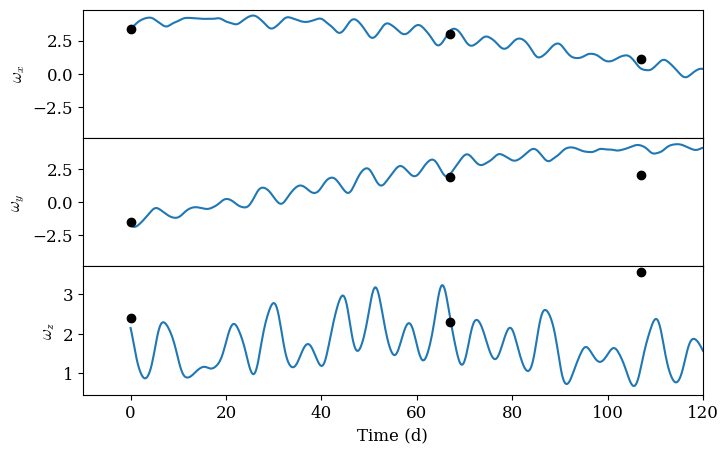

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(8, 5), sharex=True, gridspec_kw={'hspace': 0})
# for i in range(3):
#     axs[0].scatter(fid_sim.sol.t/(2*np.pi)*true_P, np.remainder(fid_sim.sol.euler[:,i], 2*np.pi), s=1, alpha=1, linestyle='None')
# axs[1].scatter(fid_sim.sol.t/(2*np.pi)*true_P, fid_sim.sol.omega, s=1, alpha=1, color='k')
# axs[2].plot(fid_sim.sol.t/(2*np.pi)*true_P, (fid_sim.sol.omega_lab.T/fid_sim.sol.omega).T, color='k')
axs[0].plot(fid_sim[i_obs].sol.t/(2*np.pi)*true_P+t_offset[i_obs], fid_sim[i_obs].sol.omega_lab[:,0],  
            label='$\omega_x$')
axs[1].plot(fid_sim[i_obs].sol.t/(2*np.pi)*true_P+t_offset[i_obs], fid_sim[i_obs].sol.omega_lab[:,1],
            label='$\omega_y$')
axs[2].plot(fid_sim[i_obs].sol.t/(2*np.pi)*true_P+t_offset[i_obs], fid_sim[i_obs].sol.omega_lab[:,2],
            label='$\omega_z$')

# axs[2].scatter(fid_sim.sol.t/(2*np.pi)*true_P, fid_sim.sol.omegaa/fid_sim.sol.omega, s=1, alpha=1, color='k')
# axs[3].scatter(fid_sim.sol.t/(2*np.pi)*true_P, fid_sim.sol.omegab/fid_sim.sol.omega, s=1, alpha=1, color='k')
# axs[4].scatter(fid_sim.sol.t/(2*np.pi)*true_P, fid_sim.sol.omegac/fid_sim.sol.omega, s=1, alpha=1, color='k')
axs[0].errorbar([0, 67, 107], [3.399, 3.026, 1.151], yerr=10.2*(2/360+1/72), linestyle='None', color='k', marker='o')
axs[1].errorbar([0, 67, 107], [-1.511, 1.909, 2.018], yerr=10.2*2/360*1/72, linestyle='None', color='k', marker='o')
axs[2].errorbar([0, 67, 107], [2.411, 2.303, 3.565], yerr=10.2*2/360*1/72, linestyle='None', color='k', marker='o')
axs[0].set_ylabel('$\omega_x$')
axs[1].set_ylabel('$\omega_y$')
axs[2].set_ylabel('$\omega_z$')
axs[-1].set_xlabel('Time (d)')
axs[0].set_xlim(-10, 120)

(0.0, 100.0)

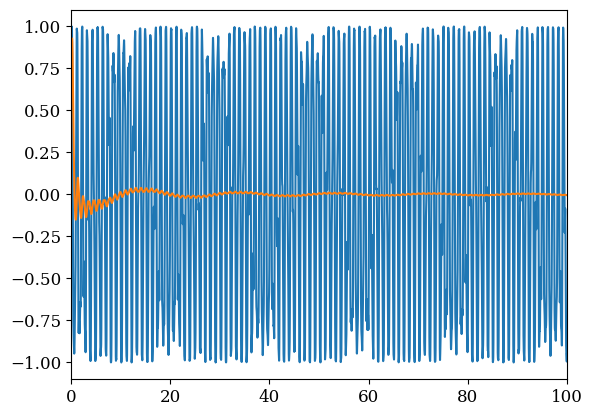

In [13]:
fs = np.array([fid_sim[i_obs].get_rf(t)[1] for t in ts])
cosines = fid_sim[i_obs].sol.cosines(fs)
cosines = np.array(cosines)
plt.plot(fid_sim[i_obs].sol.t/(2*np.pi), cosines[0])
plt.plot(fid_sim[i_obs].sol.t/(2*np.pi), np.cumsum(cosines[0])/np.arange(1, len(cosines[0])+1))
plt.xlim(0, 100)

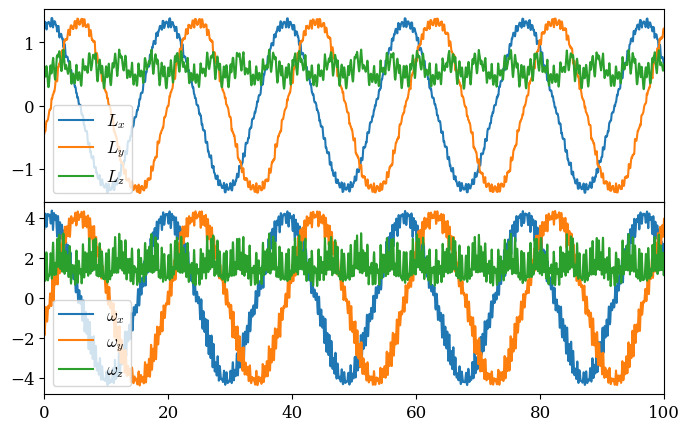

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(fid_sim[i_obs].sol.t/(2*np.pi), fid_sim[i_obs].sol.G_lab, label=['$L_x$', '$L_y$', '$L_z$'])
axs[0].legend()
axs[1].plot(fid_sim[i_obs].sol.t/(2*np.pi), fid_sim[i_obs].sol.omega_lab, label=['$\omega_x$', '$\omega_y$', '$\omega_z$'])
axs[1].set_xlim(0, 100)
axs[1].legend()

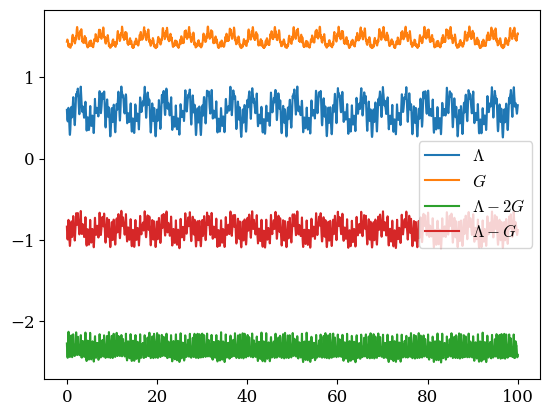

In [15]:
plt.plot(fid_sim[i_obs].sol.t/(2*np.pi), Lambda[i_obs], label='$\Lambda$')
plt.plot(fid_sim[i_obs].sol.t/(2*np.pi), G[i_obs], label='$G$')
plt.plot(fid_sim[i_obs].sol.t/(2*np.pi), Lambda[i_obs] - 2*G[i_obs], label='$\Lambda - 2G$')
plt.plot(fid_sim[i_obs].sol.t/(2*np.pi), Lambda[i_obs] - G[i_obs], label='$\Lambda - G$')
# plt.plot(fid_sim[i_obs].sol.t/(2*np.pi), Lambda - 4*G, label='$\Lambda - 4G$')
# plt.plot(fid_sim.sol.t/(2*np.pi), Lambda + G)
# plt.plot(fid_sim.sol.t/(2*np.pi), Lambda + 2*G)
# plt.plot(fid_sim.sol.t/(2*np.pi), G)
plt.legend()

In [16]:
p = Path('integration_outputs')
ham_model = {'cas1': np.loadtxt(p / 'obs1.csv', delimiter=','), 'cas2':np.loadtxt(p / 'obs2.csv', delimiter=','), 'cas3':np.loadtxt(p / 'obs3.csv', delimiter=','), 
             'cascorr1':np.loadtxt(p / 'obscorr1.csv', delimiter=','), 'cascorr2':np.loadtxt(p / 'obscorr2.csv', delimiter=','), 'cascorr3':np.loadtxt(p / 'obscorr3.csv', delimiter=','),
             'black':np.loadtxt(p / 'obsblack.csv', delimiter=',')}

[Text(0, 0.0, '0'),
 Text(0, 1.5707963267948966, '$\\pi/2$'),
 Text(0, 3.141592653589793, '$\\pi$'),
 Text(0, 4.71238898038469, '$3\\pi/2$'),
 Text(0, 6.283185307179586, '$2\\pi$')]

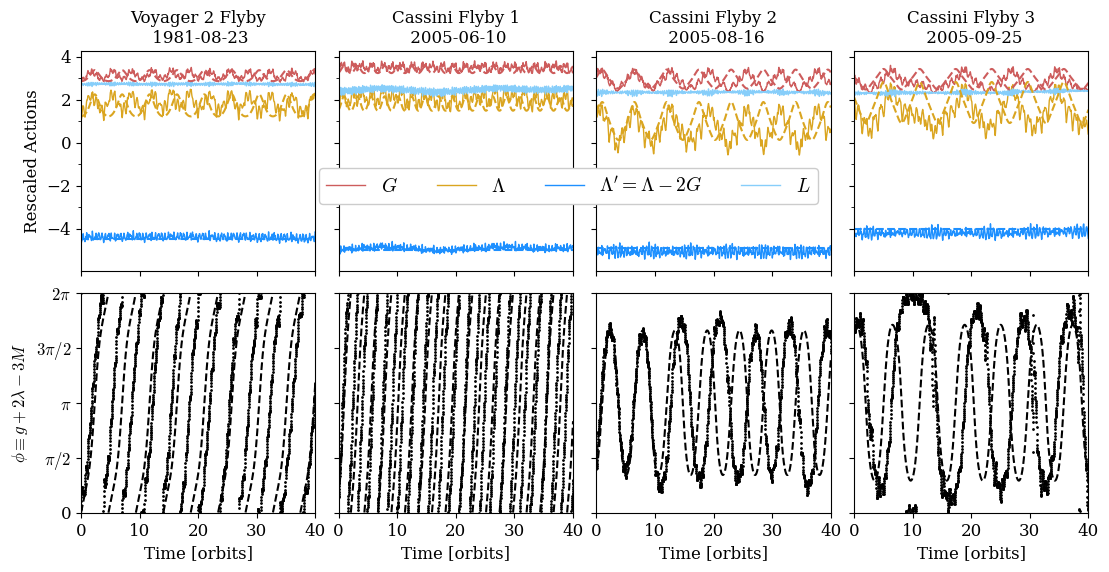

In [17]:
thinning = 2
fig, axs = plt.subplots(2, 4, figsize=(13, 6), sharex=True, sharey='row', gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
colors = {'G':'indianred', 'Lambda':'goldenrod', 'Lambda - 2G':'dodgerblue', 'L':'lightskyblue'}
for i,i_obs in enumerate(['black', 'cas1', 'cas2', 'cas3']):
    label = '' if i_obs == 'cas1' else '_'
    A = (fid_sim[i_obs].B + fid_sim[i_obs].C)/2
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), G[i_obs]/A, label=label + '$G$', lw=1, c=colors['G'])
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), Lambda[i_obs]/A, label=label + '$\Lambda$', lw=1, c=colors['Lambda'])
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), Lambda[i_obs]/A - 2*G[i_obs]/A, label=label + "$\Lambda'=\Lambda - 2G$", lw=1, c=colors['Lambda - 2G'])
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), L[i_obs]/A, label=label + '$L$', lw=1, c=colors['L'])

    axs[0,i].axhline(andoyer[i_obs][1,0]/A - 2*andoyer[i_obs][0,0]/A, linestyle='--', color=colors['Lambda - 2G'])
    axs[0,i].plot(ham_model[i_obs][:,0]/(2*np.pi), ham_model[i_obs][:,1]/A, label='', linestyle='--', color=colors['G'])
    axs[0,i].plot(ham_model[i_obs][:,0]/(2*np.pi), ham_model[i_obs][:,2]/A, label='', linestyle='--', color=colors['Lambda'])

    axs[1,i].scatter(fid_sim[i_obs].sol.t[::thinning]/(2*np.pi), np.remainder(g[i_obs] + 2*lambda_node[i_obs] - 3*M[i_obs], 2*np.pi)[::thinning], label='_$g + 2\lambda - 3M$', s=1, c='k')
    res_angle = np.remainder(ham_model[i_obs][:,3] - 3*(ham_model[i_obs][:,0] + M[i_obs][0]), 2*np.pi)
    idx_to_skip = np.append([0], np.where(np.abs(np.diff(res_angle)) > 1)[0])
    res_angle[idx_to_skip] = np.nan
    axs[1,i].plot(ham_model[i_obs][:,0]/(2*np.pi), res_angle, label='_$g$', linestyle='--', color='k')
    axs[1,i].set_xlabel('Time [orbits]')
    
axs[0,i].set_xlim(0, 40)
axs[1,i].set_ylim(0, 2*np.pi)
fig.legend(loc='upper center', ncols=4, fontsize=14, bbox_to_anchor=(0.5, 0.7), framealpha=1)
axs[1,0].set_ylabel('$\phi\equiv g + 2\lambda - 3M$')
axs[0,0].set_ylabel('Rescaled Actions')
axs[0,0].set_yticks([-4, -2, 0, 2, 4])
axs[0,0].set_yticks([-3, -1, 1, 3], minor=True)
axs[1,0].set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
axs[0,0].set_title('Voyager 2 Flyby\n 1981-08-23', fontsize=12)
axs[0,1].set_title('Cassini Flyby 1\n 2005-06-10', fontsize=12)
axs[0,2].set_title('Cassini Flyby 2\n 2005-08-16', fontsize=12)
axs[0,3].set_title('Cassini Flyby 3\n 2005-09-25', fontsize=12)
axs[1,0].set_yticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
# plt.savefig('../figs/actions.pdf', bbox_inches='tight')

[Text(0, 0.0, '0'),
 Text(0, 1.5707963267948966, '$\\pi/2$'),
 Text(0, 3.141592653589793, '$\\pi$'),
 Text(0, 4.71238898038469, '$3\\pi/2$'),
 Text(0, 6.283185307179586, '$2\\pi$')]

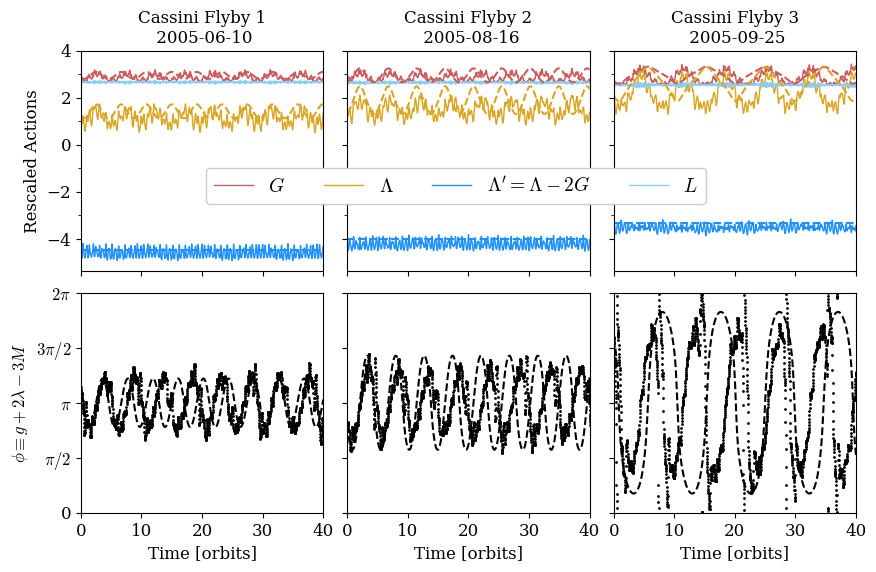

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey='row', gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
for i,i_obs in enumerate(['cascorr1', 'cascorr2', 'cascorr3']):
    label = '' if i_obs == 'cascorr1' else '_'
    A = (fid_sim[i_obs].B + fid_sim[i_obs].C)/2
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), G[i_obs]/A, label=label + '$G$', lw=1, c=colors['G'])
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), Lambda[i_obs]/A, label=label + '$\Lambda$', lw=1, c=colors['Lambda'])
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), Lambda[i_obs]/A - 2*G[i_obs]/A, label=label + "$\Lambda'=\Lambda - 2G$", lw=1, c=colors['Lambda - 2G'])
    axs[0,i].plot(fid_sim[i_obs].sol.t/(2*np.pi), L[i_obs]/A, label=label + '$L$', lw=1, c=colors['L'])
    axs[0,i].axhline(andoyer[i_obs][1,0]/A - 2*andoyer[i_obs][0,0]/A, linestyle='--', color=colors['Lambda - 2G'])
    axs[0,i].plot(ham_model[i_obs][:,0]/(2*np.pi), ham_model[i_obs][:,1]/A, label='', linestyle='--', color=colors['G'])
    axs[0,i].plot(ham_model[i_obs][:,0]/(2*np.pi), ham_model[i_obs][:,2]/A, label='', linestyle='--', color=colors['Lambda'])
    axs[1,i].scatter(fid_sim[i_obs].sol.t[::thinning]/(2*np.pi), np.remainder(g[i_obs] + 2*lambda_node[i_obs] - 3*M[i_obs], 2*np.pi)[::thinning], label='_$g + 2\lambda - 3M$', s=1, c='k')
    res_angle = np.remainder(ham_model[i_obs][:,3] - 3*(ham_model[i_obs][:,0] + M[i_obs][0]), 2*np.pi)
    idx_to_skip = np.append([0], np.where(np.abs(np.diff(res_angle)) > 1)[0])
    res_angle[idx_to_skip] = np.nan
    axs[1,i].plot(ham_model[i_obs][:,0]/(2*np.pi), res_angle, label='_$g$', linestyle='--', color='k')
    axs[1,i].set_xlabel('Time [orbits]')
    
axs[0,i].set_xlim(0, 40)
axs[1,i].set_ylim(0, 2*np.pi)
fig.legend(loc='upper center', ncols=4, fontsize=14, bbox_to_anchor=(0.5, 0.7), framealpha=1)
axs[1,0].set_ylabel('$\phi\equiv g + 2\lambda - 3M$')
axs[0,0].set_ylabel('Rescaled Actions')
axs[0,0].set_yticks([-4, -2, 0, 2, 4])
axs[0,0].set_yticks([-3, -1, 1, 3], minor=True)
axs[1,0].set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
axs[0,0].set_title('Cassini Flyby 1\n 2005-06-10', fontsize=12)
axs[0,1].set_title('Cassini Flyby 2\n 2005-08-16', fontsize=12)
axs[0,2].set_title('Cassini Flyby 3\n 2005-09-25', fontsize=12)
axs[1,0].set_yticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
# plt.savefig('../figs/actions_new_principal.pdf', bbox_inches='tight')